# Up/Down decon with stochastic gradient algorithms using numpy - multiple realizations

In this notebook, we investigate how the random selection of batches influences the final solution

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd.mdc import MDC
from stochmdd.stochmdd_numpy import SGD, ExponentialLR, MDDminibatch

## Parameters

In [2]:
datapath = '../../data/'

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

method = 'src_ana'

niter = 20

## Data loading

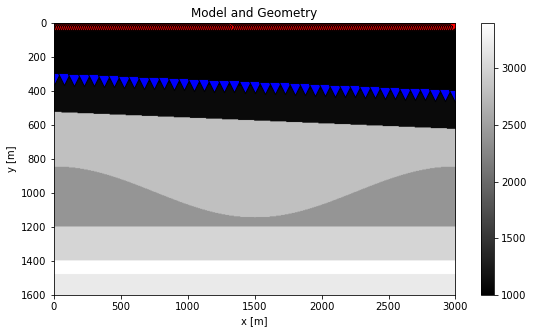

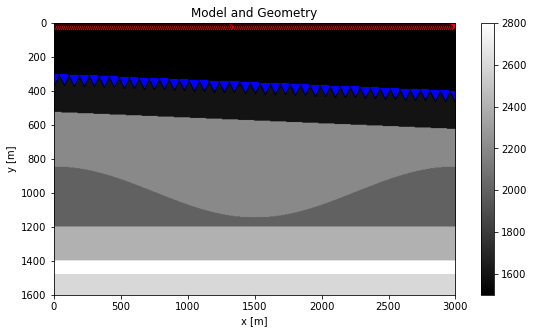

In [3]:
inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [4]:
data = np.load(os.path.join(datapath, 'updown_dipping_belowseabed_%s.npz'% method))

pup = data['pup'] 
pdown = data['pdown'] 

Reference Reflection response

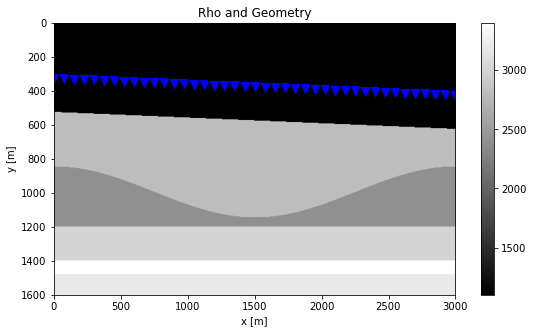

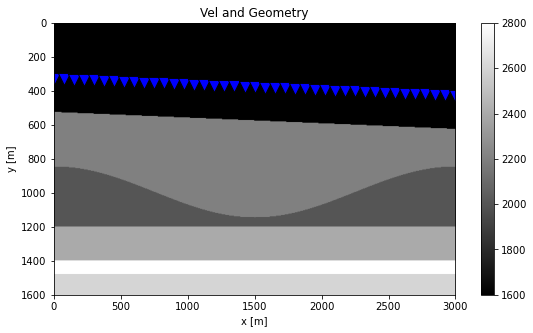

In [5]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed']

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

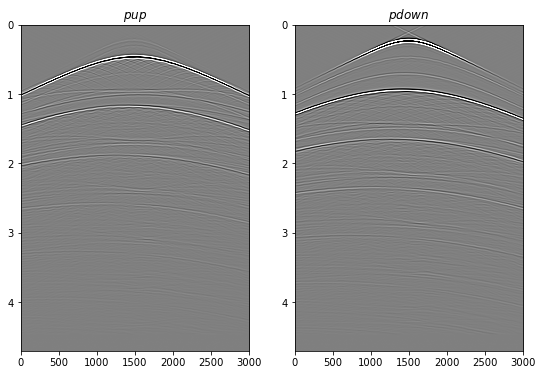

In [6]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

In [7]:
# Rescale data to of amplitude around 1
scaling = 5
pdown *= scaling
pup *= scaling

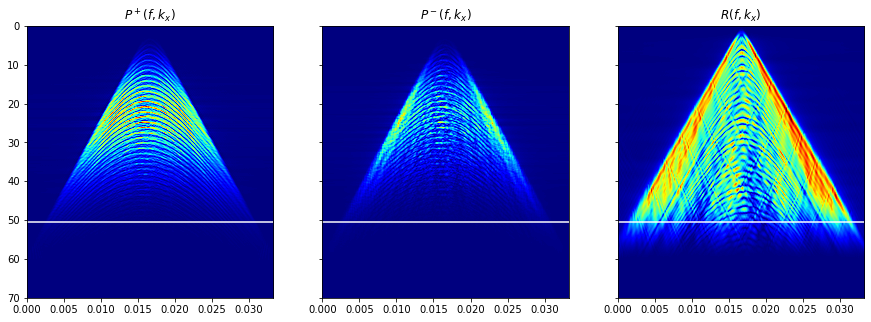

In [8]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

## Benchmark MDD

## Stochastic MDD

In [9]:
nepochs = niter
batch_size = 64

no_of_batches= int(np.ceil(ns/batch_size))
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
gnormdict = {}
mdict = {}
dr = 1. # force it to 1

In [10]:
pup = pup[:, :, nr//2].T
pdown = np.swapaxes(pdown, 2, 1)

In [11]:
pdown_fft = np.fft.rfft(pdown, ntpad, axis=-1)
pdown_fft = pdown_fft[...,:nfmax]
pdown_fft = pdown_fft.transpose(2,0,1)

MDCop=MDC(pdown_fft, nt=ntpad, nv=1, dt=dt, dr=dr, 
          twosided=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True);

Dot test passed, v^T(Opu)=1200.072047 - u^T(Op^Tv)=1200.072047


### SGD with momentum and exponential LR

In [12]:
lr = {}
lr[64] = 6. / (batch_size * ntpad) # not sure why i need more...

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], lr = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, mtrue=R, seed=0, enormabsscaling=True,
                              scheduler=ExponentialLR, epochprint=5, savegradnorm=True,
                              kwargs_sched=dict(gamma=0.99),
                              **dict(lr=lr[batch_size], momentum=0.9, nesterov=True))
                 
mdict["SGDMom_LRexp"] = model

Initial Loss norm: 1.159088e-02
Initial Gradient norm: 2.129198e-05, scaled by lr: 1.905510e-13
epoch:   5, loss : 1.3102e-04, loss avg : 7.3993e-04
epoch:  10, loss : 2.8220e-05, loss avg : 1.6853e-04
epoch:  15, loss : 1.1602e-05, loss avg : 5.7878e-05
epoch:  20, loss : 6.5592e-06, loss avg : 3.6324e-05
Time: 7.894509 s


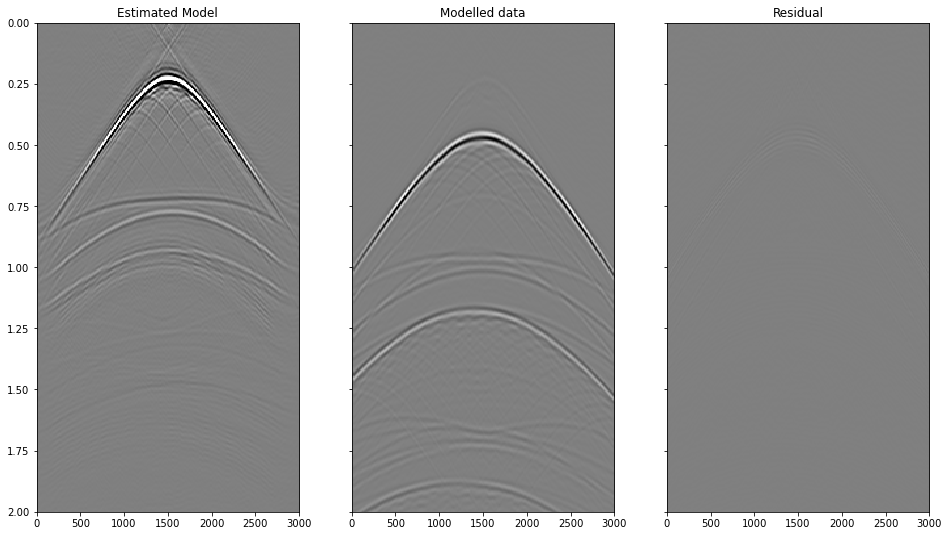

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

In [14]:
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
gnormdict = {}
mdict = {}

In [15]:
lr = {}
lr[64] = 6. / (batch_size * ntpad) # not sure why i need more...

seeds = np.random.uniform(0, 100, 30).astype(np.int)
for iseed in seeds:
    print('Working with seed %d' % iseed)
    model, dmod, lossdict["Seed%d" % iseed], avgdict["Seed%d" % iseed], lossepochdict["Seed%d" % iseed], enormdict["Seed%d" % iseed], _ = \
                     MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                                  nepochs, batch_size, twosided=False, mtrue=R, seed=iseed, enormabsscaling=True,
                                  scheduler=ExponentialLR, epochprint=5, savegradnorm=True,
                                  kwargs_sched=dict(gamma=0.99),
                                  **dict(lr=lr[batch_size], momentum=0.9, nesterov=True))

    mdict["Seed%d" % iseed] = model.copy()

Working with seed 7
Initial Loss norm: 1.145571e-02
Initial Gradient norm: 2.013238e-05, scaled by lr: 1.801732e-13
epoch:   5, loss : 1.2680e-04, loss avg : 8.3590e-04
epoch:  10, loss : 3.5484e-05, loss avg : 1.6322e-04
epoch:  15, loss : 9.7731e-06, loss avg : 5.9321e-05
epoch:  20, loss : 6.3994e-06, loss avg : 3.6615e-05
Time: 7.544732 s
Working with seed 85
Initial Loss norm: 1.169391e-02
Initial Gradient norm: 2.120621e-05, scaled by lr: 1.897834e-13
epoch:   5, loss : 1.4499e-04, loss avg : 8.7643e-04
epoch:  10, loss : 3.3796e-05, loss avg : 1.7871e-04
epoch:  15, loss : 1.2671e-05, loss avg : 5.9935e-05
epoch:  20, loss : 7.4439e-06, loss avg : 3.6784e-05
Time: 7.565760 s
Working with seed 71
Initial Loss norm: 1.245958e-02
Initial Gradient norm: 2.355712e-05, scaled by lr: 2.108227e-13
epoch:   5, loss : 1.3860e-04, loss avg : 1.2383e-03
epoch:  10, loss : 3.0879e-05, loss avg : 1.9881e-04
epoch:  15, loss : 9.1806e-06, loss avg : 6.3403e-05
epoch:  20, loss : 7.1681e-06, lo

epoch:  20, loss : 5.3923e-06, loss avg : 3.6265e-05
Time: 7.572890 s
Working with seed 69
Initial Loss norm: 1.119975e-02
Initial Gradient norm: 1.970727e-05, scaled by lr: 1.763688e-13
epoch:   5, loss : 1.7351e-04, loss avg : 9.0229e-04
epoch:  10, loss : 3.5449e-05, loss avg : 1.9732e-04
epoch:  15, loss : 1.3532e-05, loss avg : 7.2218e-05
epoch:  20, loss : 6.3199e-06, loss avg : 3.7779e-05
Time: 7.460756 s
Working with seed 19
Initial Loss norm: 1.157833e-02
Initial Gradient norm: 2.093447e-05, scaled by lr: 1.873515e-13
epoch:   5, loss : 1.5872e-04, loss avg : 9.8888e-04
epoch:  10, loss : 3.1674e-05, loss avg : 2.1499e-04
epoch:  15, loss : 1.2983e-05, loss avg : 6.4865e-05
epoch:  20, loss : 7.9398e-06, loss avg : 3.7078e-05
Time: 7.585234 s
Working with seed 28
Initial Loss norm: 1.136420e-02
Initial Gradient norm: 2.127094e-05, scaled by lr: 1.903627e-13
epoch:   5, loss : 1.0719e-04, loss avg : 8.8627e-04
epoch:  10, loss : 2.3889e-05, loss avg : 1.5442e-04
epoch:  15, los

In [16]:
# Statistics
enormdict["Mean"] = np.mean(np.array([enormdict["Seed%d" % iseed] for iseed in seeds]), axis=0)
enormdict["Std"] = np.std(np.array([enormdict["Seed%d" % iseed] for iseed in seeds]), axis=0)

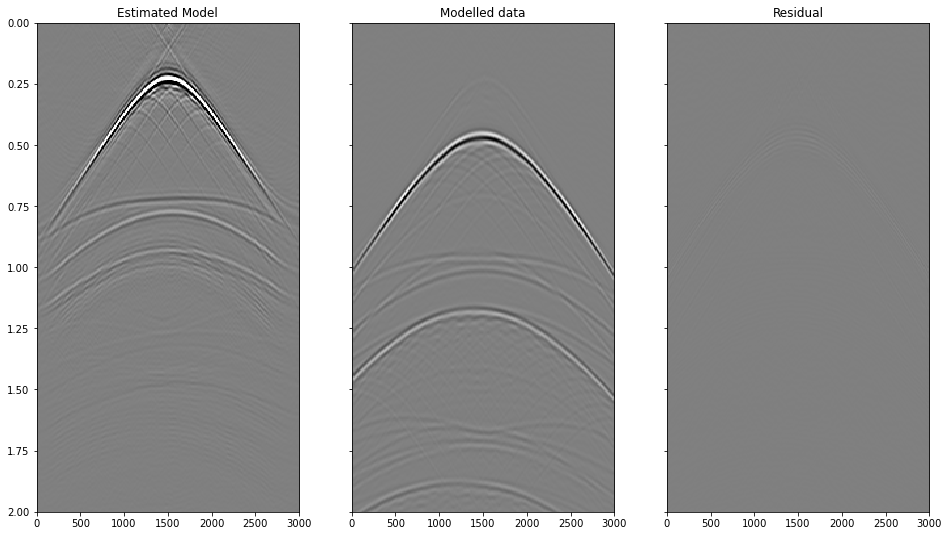

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Modelled data')
ax3.imshow((dmod-pup), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-pup.max(), vmax=pup.max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Residual')
ax3.set_ylim(2, 0);

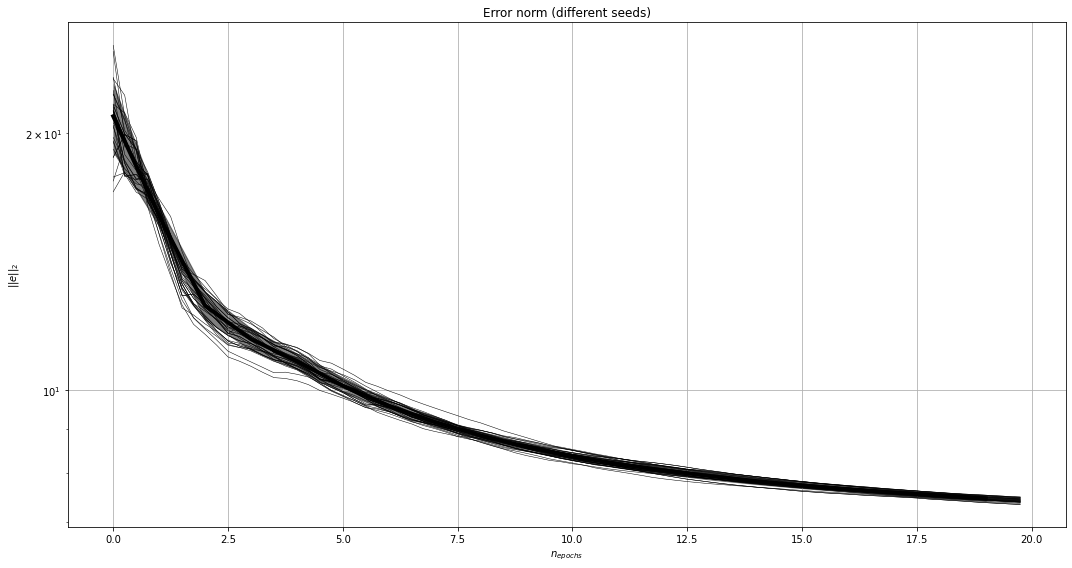

In [19]:
fig, ax = plt.subplots(1, 1, figsize= (15,8))
for enorm in seeds:
    enorm='Seed%d' %enorm
    ax.semilogy(np.arange(len(enormdict[enorm]))/no_of_batches, enormdict[enorm], 
               'k', ms=10, label=r"%s ($MSE_{min}=%.2f)$" % (enorm, np.array(enormdict[enorm]).min()), linewidth=0.5)
    #ax.semilogy((np.arange(len(enormdict[enorm]))/no_of_batches)[::no_of_batches], enormdict[enorm][::no_of_batches],
    #            '.k', ms=10, linewidth=0.5)
ax.semilogy((np.arange(len(enormdict['Mean']))/no_of_batches)[::no_of_batches], enormdict['Mean'][::no_of_batches],
                'k', ms=10, linewidth=4)
ax.fill_between((np.arange(len(enormdict['Mean']))/no_of_batches)[::no_of_batches], 
                    enormdict['Mean'][::no_of_batches]-enormdict['Std'][::no_of_batches],
                    enormdict['Mean'][::no_of_batches]+enormdict['Std'][::no_of_batches],
                    color='k', alpha=0.5)
ax.grid()
ax.set_xlabel(r'$n_{epochs}$')
ax.set_ylabel(r'$||e||_2$')
ax.set_title("Error norm (different seeds)")
#ax.legend()
fig.tight_layout();